In [27]:
import os
os.chdir("C:/Users/Win11/Documents/Repos/Acorn-Casino-PLTV/")

import pickle
import pandas as pd
from urllib.parse import urlencode
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


# Revision of predictions from ETL 

In [28]:
# Load BI Tool data 
file_path = (os.getcwd()).replace('\\', '/') + r'/roi_all_by_user_20240126114811.xlsx'.replace('\\', '/')
bi_tool_actuals = pd.read_excel(file_path)
bi_tool_actuals = bi_tool_actuals[bi_tool_actuals['date'] != '--']
# bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date'])
bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date'].astype(str), format='%Y%m%d')

print('Date range:', bi_tool_actuals['date'].min(), ' ', bi_tool_actuals['date'].max())

bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)']].sort_values(by = 'date').head(10)


Date range: 2023-11-08 00:00:00   2024-01-18 00:00:00


,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate)
71,2023-11-08,"4,975.01 (36.28%)","7,668.44 (55.92%)","16,387.03 (119.5%)"
70,2023-11-09,"2,298.62 (15.38%)","3,588.79 (24.01%)","4,962.28 (33.2%)"
69,2023-11-10,"11,288.82 (69.2%)","25,256.77 (154.81%)","37,694.67 (231.05%)"
68,2023-11-11,"2,622.44 (16.48%)","3,771.83 (23.71%)","9,822.25 (61.74%)"
67,2023-11-12,"7,123.44 (42.87%)","10,995.05 (66.17%)","14,381.77 (86.56%)"
66,2023-11-13,"2,641.14（15.98%）","4,017.01（24.31%）","5,039.40（30.5%）"
65,2023-11-14,"2,633.08（15.81%）","3,847.72（23.11%）","4,954.05（29.75%）"
64,2023-11-15,"1,956.68（11.26%）","2,283.08（13.14%）","3,897.57（22.44%）"
63,2023-11-16,"2,587.26（16.46%）","4,044.17（25.72%）","5,351.50（34.04%）"
62,2023-11-17,"3,549.81（19.97%）","4,594.79（25.85%）","6,578.70（37.01%）"


In [29]:
# Convert percentage strings to floats
def convert_percentage_string_to_float(percentage_string):
    try:
        return float(percentage_string.split(' ')[1][1:-2]) / 100
    except (ValueError, IndexError):
        return float(percentage_string.split('（')[1][0:-2]) / 100

for col in ['7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)', '35-day recovery (rate)']:
    bi_tool_actuals[col] = bi_tool_actuals[col].apply(convert_percentage_string_to_float)

bi_tool_actuals[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)', '35-day recovery (rate)']].sort_values(by = 'date').head()


,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate),35-day recovery (rate)
71,2023-11-08,0.3628,0.5592,1.1950,1.3250
70,2023-11-09,0.1538,0.2401,0.3320,0.5352
69,2023-11-10,0.6920,1.5481,2.3105,2.4895
68,2023-11-11,0.1648,0.2371,0.6174,0.8635
67,2023-11-12,0.4287,0.6617,0.8656,0.8628


In [37]:
# Calculate percentage increase for each row
bi_tool_actuals['percentage_increase_7_28'] = ((bi_tool_actuals['Recovery on the 28th (rate)'] - bi_tool_actuals['7-day recovery (rate)']) / bi_tool_actuals['7-day recovery (rate)']) # This cannot be trusted (because we give the same weight to every install)
bi_tool_actuals['percentage_increase_14_28'] = ((bi_tool_actuals['Recovery on the 28th (rate)'] - bi_tool_actuals['14-day recycling (rate)']) / bi_tool_actuals['14-day recycling (rate)'])

# Calculate average percentage increase grouped by 'channel'
average_percentage_increase_by_channel = bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'][['percentage_increase_7_28', 'percentage_increase_14_28']].mean().reset_index()
median_percentage_increase_by_channel = bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'][['percentage_increase_7_28', 'percentage_increase_14_28']].median().reset_index()

bi_tool_actuals['channel'] = 'All'
total_installs = bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'].groupby('channel')['Register new'].mean().sum()
installs_per_channel = bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'].groupby('channel')[['Register new', 'percentage_increase_7_28', 'percentage_increase_14_28']].mean().reset_index() # This cannot be trusted (because we give the same weight to every install)
installs_per_channel['proportion'] = installs_per_channel['Register new'] / total_installs

# Add a column determining the metric
average_percentage_increase_by_channel['metric'] = 'average'
median_percentage_increase_by_channel['metric'] = 'median'

# Concatenate the DataFrames
percentage_increase_by_channel = pd.concat([average_percentage_increase_by_channel, median_percentage_increase_by_channel], ignore_index=True)
print(installs_per_channel)
percentage_increase_by_channel


  channel  Register new  percentage_increase_7_28  percentage_increase_14_28  \
0     All   1376.194444                  1.294644                   0.545204   

   proportion  
0         1.0  


,index,0,metric
0,percentage_increase_7_28,1.294644,average
1,percentage_increase_14_28,0.545204,average
2,percentage_increase_7_28,1.160607,median
3,percentage_increase_14_28,0.482199,median


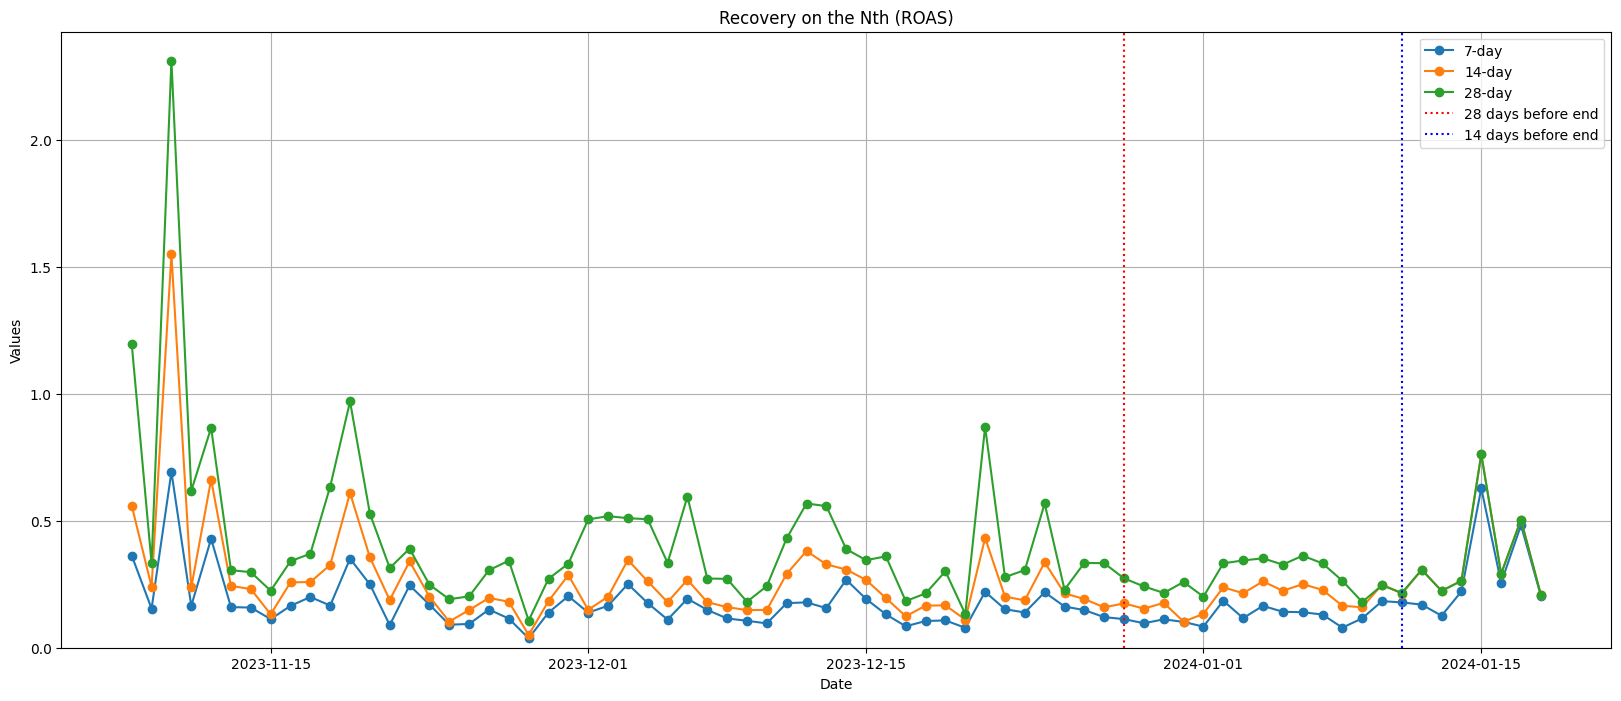

In [38]:
a =  bi_tool_actuals[bi_tool_actuals['date'] > '2023-10-31'][bi_tool_actuals['channel'] == 'All'].copy()
a['date'] = pd.to_datetime(a['date'], format='%Y%m%d')

plt.figure(figsize=(20, 8))  # Adjust width and height as needed

# Plotting both 'pred_56' and 'pred_100'
plt.plot(a['date'], a['7-day recovery (rate)'], marker='o', label='7-day')
plt.plot(a['date'], a['14-day recycling (rate)'], marker='o', label='14-day')
plt.plot(a['date'], a['Recovery on the 28th (rate)'], marker='o', label='28-day')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()  # Get the current date
target_date = current_date - timedelta(days=29)
plt.axvline(target_date, color='red', linestyle='dotted', label='28 days before end')

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()  # Get the current date
target_date = current_date - timedelta(days=15)
plt.axvline(target_date, color='blue', linestyle='dotted', label='14 days before end')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Recovery on the Nth (ROAS)')
plt.grid(True)
plt.legend()  # Add legend to differentiate between pred_56 and pred_100
plt.show()


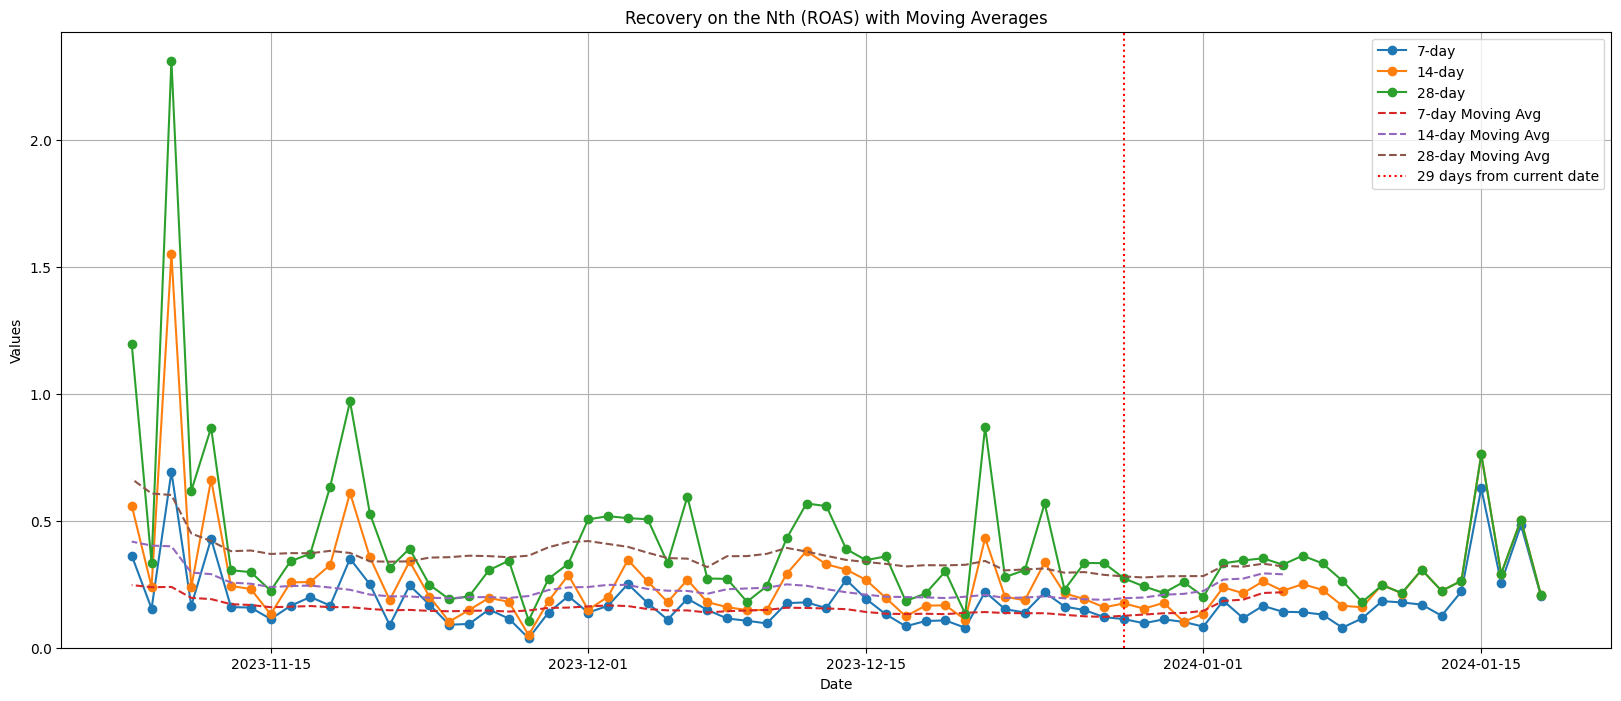

In [39]:
a['date'] = pd.to_datetime(a['date'], format='%Y%m%d')

plt.figure(figsize=(20, 8))

# Plotting both '7-day recovery (rate)', '14-day recycling (rate)', and 'Recovery on the 28th (rate)'
plt.plot(a['date'], a['7-day recovery (rate)'], marker='o', label='7-day')
plt.plot(a['date'], a['14-day recycling (rate)'], marker='o', label='14-day')
plt.plot(a['date'], a['Recovery on the 28th (rate)'], marker='o', label='28-day')

# Calculate and plot 7-day moving average
ma_7day = a['7-day recovery (rate)'].rolling(window=14).mean()
plt.plot(a['date'], ma_7day, label='7-day Moving Avg', linestyle='dashed')

# Calculate and plot 14-day moving average
ma_14day = a['14-day recycling (rate)'].rolling(window=14).mean()
plt.plot(a['date'], ma_14day, label='14-day Moving Avg', linestyle='dashed')

# Calculate and plot 28-day moving average
ma_28day = a['Recovery on the 28th (rate)'].rolling(window=14).mean()
plt.plot(a['date'], ma_28day, label='28-day Moving Avg', linestyle='dashed')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()
target_date = current_date - timedelta(days=29)
plt.axvline(target_date, color='red', linestyle='dotted', label='29 days from current date')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Recovery on the Nth (ROAS) with Moving Averages')
plt.grid(True)
plt.legend()
plt.show()


In [43]:
file_path = 'bi_report_20240126.csv'

# # Load the CSV file into a DataFrame
etl_output = pd.read_csv(file_path)
etl_output['date'] = pd.to_datetime(etl_output['date'], format = '%Y%m%d')
bi_tool_actuals['date'] = pd.to_datetime(bi_tool_actuals['date'], format = '%Y%m%d')
a = pd.merge(bi_tool_actuals[bi_tool_actuals['date'] > '2023-12-16'], etl_output, on='date')


In [44]:
etl_output.sample(30)

,date,pred_14,pred_28,pred_56,pred_63,pred_70,pred_77,pred_84,pred_91,pred_98,pred_100,pred_105,pred_112,pred_119,pred_126,pred_133,roas_d100_error,pred_payback,pb_window_error
12,2023-12-31,NaN,1.526469,2.180408,2.343893,2.507378,2.670863,2.834348,2.997833,3.161318,3.208027,3.324802,3.488287,3.651772,3.815257,3.978742,0.051086,31,2.0
21,2024-01-09,NaN,2.026587,2.894777,3.111824,3.328872,3.545919,3.762967,3.980014,4.197061,4.259075,4.414109,4.631156,4.848204,5.065251,5.282299,0.053585,31,2.0
28,2024-01-16,1.496000,1.581058,2.258383,2.427715,2.597046,2.766377,2.935708,3.105040,3.274371,3.322751,3.443702,3.613034,3.782365,3.951696,4.121028,0.048624,22,1.0
17,2024-01-05,NaN,1.116378,1.594634,1.714198,1.833763,1.953327,2.072891,2.192455,2.312019,2.346180,2.431583,2.551147,2.670711,2.790275,2.909839,0.057196,14,1.0
3,2023-12-22,NaN,NaN,0.515078,0.553698,0.592318,0.630938,0.669558,0.708178,0.746798,0.757832,0.785418,0.824038,0.862658,0.901278,0.939898,0.056792,174,13.0
13,2024-01-01,NaN,1.432380,2.046012,2.199420,2.352828,2.506236,2.659644,2.813052,2.966460,3.010291,3.119868,3.273276,3.426684,3.580092,3.733499,0.058004,37,3.0
0,2023-12-19,NaN,NaN,0.373013,0.400981,0.428949,0.456917,0.484885,0.512853,0.540821,0.548812,0.568789,0.596757,0.624725,0.652694,0.680662,0.048484,276,17.0
30,2024-01-18,1.274441,1.699854,2.428072,2.610126,2.792181,2.974235,3.156290,3.338344,3.520398,3.572414,3.702453,3.884507,4.066562,4.248616,4.430670,0.091196,5,1.0
15,2024-01-03,NaN,1.531290,2.187295,2.351296,2.515297,2.679298,2.843299,3.007300,3.171301,3.218159,3.335303,3.499304,3.663305,3.827306,3.991307,0.053667,36,3.0
9,2023-12-28,NaN,NaN,0.383395,0.412141,0.440888,0.469634,0.498381,0.527127,0.555874,0.564087,0.584620,0.613367,0.642114,0.670860,0.699607,0.050921,269,18.0


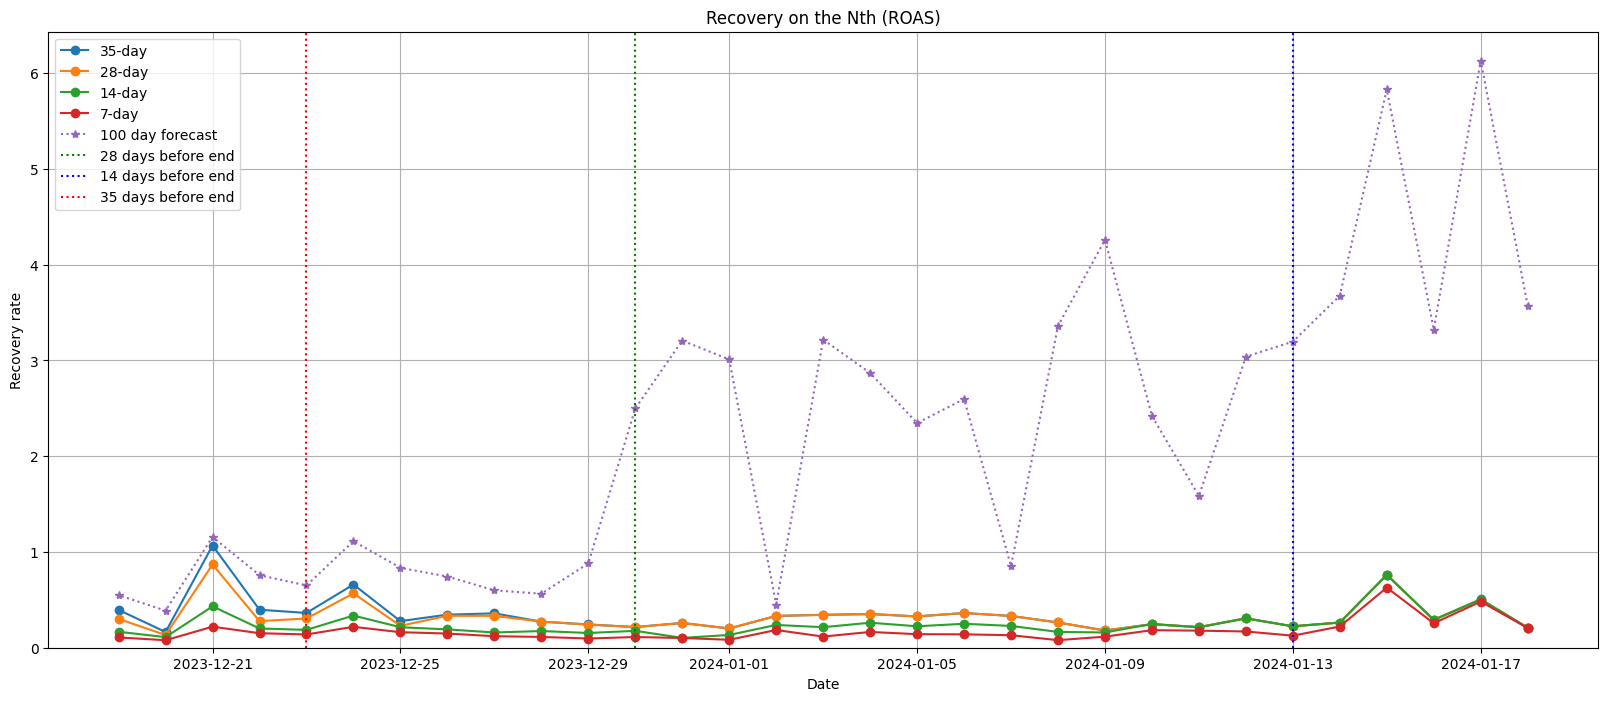

In [45]:
plt.figure(figsize=(20, 8))  # Adjust width and height as needed

# Plotting both 'pred_56' and 'pred_100'
plt.plot(a['date'], a['35-day recovery (rate)'], marker='o', label='35-day')
plt.plot(a['date'], a['Recovery on the 28th (rate)'], marker='o', label='28-day')
plt.plot(a['date'], a['14-day recycling (rate)'], marker='o', label='14-day')
plt.plot(a['date'], a['7-day recovery (rate)'], marker='o', label='7-day')

plt.plot(a['date'], a['pred_100'], marker='*', label='100 day forecast', linestyle='dotted')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()# Get the current date
target_date = current_date - timedelta(days=27)
plt.axvline(target_date, color='green', linestyle='dotted', label='28 days before end')

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()  # Get the current date
target_date = current_date - timedelta(days=13)
plt.axvline(target_date, color='blue', linestyle='dotted', label='14 days before end')

# Add a vertical dotted line for the day that is 29 days from the current date
current_date = datetime.now().date()  # Get the current date
target_date = current_date - timedelta(days=34)
plt.axvline(target_date, color='red', linestyle='dotted', label='35 days before end')


plt.xlabel('Date')
plt.ylabel('Recovery rate')
plt.title('Recovery on the Nth (ROAS)')
plt.grid(True)
plt.legend()  # Add legend to differentiate between pred_56 and pred_100
plt.show()

# I want to join etl_output and bi_tolito, then I want to. Create a column that groups dates by 1,2,3. Now crea

# Create a column that groups dates into 1, 2, or 3
# df['group'] = np.select([df['date'] < 'date_A', df['date'] < 'date_B'], [1, 2], default=3)

# Create columns 'official_day_14' and 'official_day_28'
# df['official_day_14'] = np.where(df['group'] > 1, df['pred_14'], df['roas_14'])
# df['official_day_28'] = np.where(df['group'] > 2, df['pred_28'], df['roas_28'])


## Average increases

Something that you can do is see if the ratios on the predictions are similar to the ratios observed in the past for big samples. This can give you an understanding of the bias in the estimations 

In [46]:
a[['date', '7-day recovery (rate)', '14-day recycling (rate)', 'Recovery on the 28th (rate)', '35-day recovery (rate)']].sort_values(by = 'date')

,date,7-day recovery (rate),14-day recycling (rate),Recovery on the 28th (rate),35-day recovery (rate)
30,2023-12-19,0.1075,0.1667,0.3007,0.3949
29,2023-12-20,0.0783,0.1106,0.1325,0.1640
28,2023-12-21,0.2199,0.4318,0.8694,1.0674
27,2023-12-22,0.1516,0.2010,0.2780,0.3967
26,2023-12-23,0.1386,0.1865,0.3054,0.3633
25,2023-12-24,0.2183,0.3360,0.5676,0.6599
24,2023-12-25,0.1621,0.2140,0.2286,0.2777
23,2023-12-26,0.1481,0.1915,0.3337,0.3454
22,2023-12-27,0.1203,0.1590,0.3326,0.3592
21,2023-12-28,0.1127,0.1744,0.2727,0.2720


In [47]:
# first_duplicate_index = a.duplicated(subset=['14-day recycling (rate)', 'Recovery on the 28th (rate)'])
a['14_not_useful'] = (a['14-day recycling (rate)'] == a['Recovery on the 28th (rate)']).astype(int)
a['28_not_useful'] = (a['Recovery on the 28th (rate)'] == a['35-day recovery (rate)']).astype(int)


In [48]:
# Conditionally replace values based on 14_not_useful and 28_not_useful
# a.loc[a['14_not_useful'] == 1, '14-day recycling (rate)'] = np.where(a['14_not_useful'] == 1, a['pred_14'], a['14-day recycling (rate)'])
# a.loc[a['28_not_useful'] == 1, '28-day recycling (rate)'] = np.where(a['28_not_useful'] == 1, a['pred_28'], a['28-day recycling (rate)'])

# Conditionally replace values based on 14_not_useful and 28_not_useful
a['effective_d14_roas'] = np.where(a['14_not_useful'] == 1, a['pred_14'], a['14-day recycling (rate)'])
a['effective_d28_roas'] = np.where(a['28_not_useful'] == 1, a['pred_28'], a['Recovery on the 28th (rate)'])


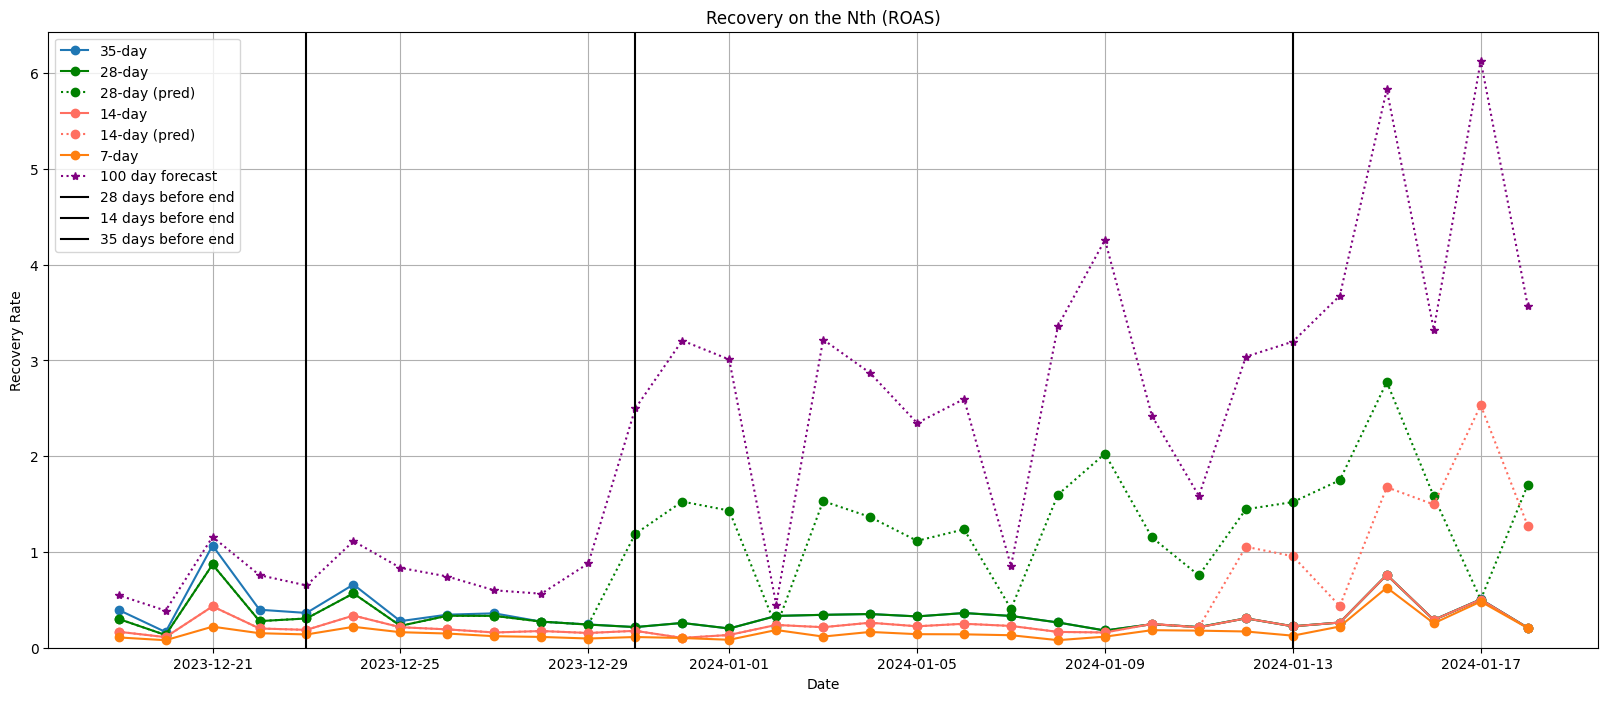

In [50]:
plt.figure(figsize=(20, 8))

# Plotting the data
plt.plot(a['date'], a['35-day recovery (rate)'], marker='o', label='35-day')
plt.plot(a['date'], a['Recovery on the 28th (rate)'], marker='o', label='28-day', color = 'green')
plt.plot(a['date'], a['effective_d28_roas'], marker='o', label='28-day (pred)', linestyle='dotted', color = 'green')
plt.plot(a['date'], a['14-day recycling (rate)'], marker='o', label='14-day', color = '#FF6F61')
plt.plot(a['date'], a['effective_d14_roas'], marker='o', label='14-day (pred)', linestyle='dotted', color='#FF6F61')  # Coralle Orange
plt.plot(a['date'], a['7-day recovery (rate)'], marker='o', label='7-day')

# Plotting the 100-day forecast with a solid line
plt.plot(a['date'], a['pred_100'], marker='*', label='100 day forecast', color = '#800080', linestyle='dotted')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add vertical lines with solid black color
current_date = datetime.now().date()
target_date = current_date - timedelta(days=27)
plt.axvline(target_date, color='black', linestyle='-', label='28 days before end')

current_date = datetime.now().date()
target_date = current_date - timedelta(days=13)
plt.axvline(target_date, color='black', linestyle='-', label='14 days before end')

current_date = datetime.now().date()
target_date = current_date - timedelta(days=34)
plt.axvline(target_date, color='black', linestyle='-', label='35 days before end')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Recovery Rate')
plt.title('Recovery on the Nth (ROAS)')
plt.legend()

plt.grid(True)
plt.show()

